# Introduction to Entity Linking

This notebook provides a short tutorial on how to implement and use spaCy's Entity Linking functionality. It can be used together with [this video](https://www.youtube.com/watch?v=8u57WSXVpmw).

**Entity Linking** (EL) is the challenge of resolving ambiguous textual mentions to unique concepts in a knowledge base. A related task is **Named Entity Recognition** (NER). An NER component basically identifies words in text that have a specific name and refer to real-world objects, such as people or organizations. spaCy offers pre-built Machine Learning models that perform Named Entity Recognition for a variety of languages (https://spacy.io/models).

In [ ]:
!pip install spacy==2.2.4
!python -m spacy download en_core_web_lg

Let's load a  pretrained English model, apply it to some sample text and show the named entities that were identified by printing their text and label.

In [ ]:
import spacy
nlp = spacy.load("en_core_web_lg")
text = "Tennis champion Emerson was expected to win Wimbledon."
doc = nlp(text)
for ent in doc.ents:
    print(f"Named Entity '{ent.text}' with label '{ent.label_}'")

We see that this sentence contains a person called "Emerson" and an organization called "Wimbledon". 

Unfortunately, there may be many people in the world called "Emerson", and this output still doesn't tell us which one exactly we meant. This is the challenge addressed by Entity Linking. It transforms an ambiguous textual mention to a unique identifier by looking at the context in which the mention occurs. 

In this specific case, the sentence gives us important clues: Emerson is clearly a professional tennis player. 

Searching the internet, we can establish that this sentence is most likely talking about Roy Emerson, an Australian tennis player. We can now resolve this entity in this sentence to its unique identifier from WikiData, which is a free and open, interlingual knowledge base. Its unique IDs always start with a Q, and "Roy Emerson" has the identifier Q312545: https://www.wikidata.org/wiki/Q312545

To implement an entity linking pipeline, we need 3 different steps. 

The first step, as we already saw, is Named Entity Recognition, in which the mention "Emerson" is labeled as a "Person". Next, the extracted mention needs to be resolved to a list of plausible candidates. In our case, we'll consider three different people named Emerson. Typically, this list is created by querying a knowledge base (KB) that contains various aliases and synonyms. In the final step, we need to reduce the list of candidates to just one final ID that represents the correct Emerson.

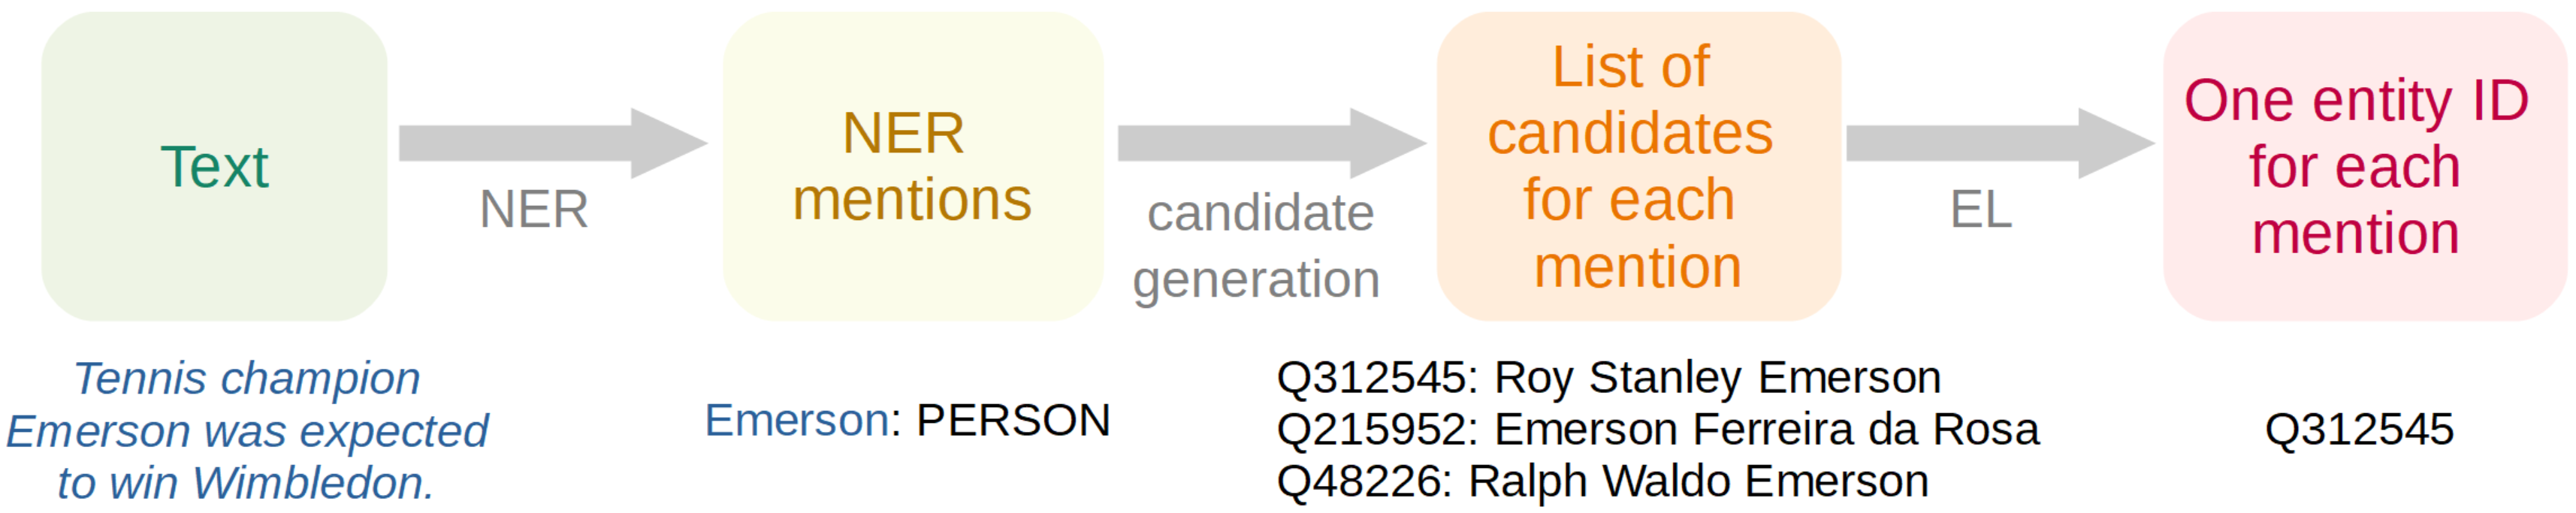

This tutorial will show you how to use spaCy to create a Knowledge base that will address the second step of candidate generation. Additionally, we will create a new Entity Linking component, and train its Machine Learning model on some annotated data.

The aim of this tutorial is to help you get started implementing your own Entity Linking functionality with spaCy. If you want to know more about the technical details, checkout this presentation at spaCy IRL 2019: https://www.youtube.com/watch?v=PW3RJM8tDGo&list=PLBmcuObd5An4UC6jvK_-eSl6jCvP1gwXc&index=7&t=0s

# Creating the Knowledge Base 

The first step to perform Entity Linking, is to set up a knowledge base that contains the unique identifiers of the entities we are interested in. In this tutorial we will create a very simple one with only 3 entries. We load the data from a pre-defined CSV file.

In [ ]:
import csv
from pathlib import Path

def load_entities():
    entities_loc = Path.cwd().parent / "input" / "entities.csv"  # distributed alongside this notebook

    names = dict()
    descriptions = dict()
    with entities_loc.open("r", encoding="utf8") as csvfile:
        csvreader = csv.reader(csvfile, delimiter=",")
        for row in csvreader:
            qid = row[0]
            name = row[1]
            desc = row[2]
            names[qid] = name
            descriptions[qid] = desc
    return names, descriptions

In [ ]:
name_dict, desc_dict = load_entities()
for QID in name_dict.keys():
    print(f"{QID}, name={name_dict[QID]}, desc={desc_dict[QID]}")

We have 3 entries here, of 3 different people called Emerson. One Australian tennis player, one American writer and one Brazilian footballer. We'll use this information to create our knowledge base. We need to define a fixed dimensionality for the entity vectors, which will be 300-D in our case.

In [ ]:
from spacy.kb import KnowledgeBase
kb = KnowledgeBase(vocab=nlp.vocab, entity_vector_length=300)

To add each record to the knowledge base, we encode its description using the built-in word vectors of our `nlp` model. The `vector` attribute of a document is the average of its token vectors. We also need to provide a frequency, which is a raw count of how many times a certain entity appears in an annotated corpus. In this tutorial we're not using these frequencies, so we're setting them to an arbitrary value.

In [ ]:
for qid, desc in desc_dict.items():
    desc_doc = nlp(desc)
    desc_enc = desc_doc.vector
    kb.add_entity(entity=qid, entity_vector=desc_enc, freq=342)   # 342 is an arbitrary value here

Now we want to specify aliases or synonyms. We first add the full names. Here, we are 100% certain that they resolve to their corresponding QID, as there is no ambiguity.

In [ ]:
for qid, name in name_dict.items():
    kb.add_alias(alias=name, entities=[qid], probabilities=[1])   # 100% prior probability P(entity|alias)

We also want to add the alias "Emerson". We'll assume that each of our 3 Emersons is equally famous and thus we set their probabilities to be equal for each entity.

In [ ]:
qids = name_dict.keys()
probs = [0.3 for qid in qids]
kb.add_alias(alias="Emerson", entities=qids, probabilities=probs)  # sum([probs]) should be <= 1 !

So this will be our Knowledge base. We can check the entities and aliases that are contained in it:

In [ ]:
print(f"Entities in the KB: {kb.get_entity_strings()}")
print(f"Aliases in the KB: {kb.get_alias_strings()}")

We can also print the candidates that are generated for the full name of Roy Emerson, as well as for the mention "Emerson" or for any other random mention, like "Sofie".

In [ ]:
print(f"Candidates for 'Roy Stanley Emerson': {[c.entity_ for c in kb.get_candidates('Roy Stanley Emerson')]}")
print(f"Candidates for 'Emerson': {[c.entity_ for c in kb.get_candidates('Emerson')]}")
print(f"Candidates for 'Sofie': {[c.entity_ for c in kb.get_candidates('Sofie')]}")

We notice that querying the KB with the alias "Emerson" gives us 3 candidates, but if we query it with an unknown term, it just gives an empty list.

We can save the knowledge base by calling the function `dump` with an output location.

In [ ]:
# change the directory and file names to whatever you like
import os
output_dir = Path.cwd().parent / "my_output"
if not os.path.exists(output_dir):
    os.mkdir(output_dir) 
kb.dump(output_dir / "my_kb")

We can store the `nlp` object to file by calling `to_disk`.

In [ ]:
nlp.to_disk(output_dir / "my_nlp")

# Creating a training dataset

Now, we need to create some annotated data to train an Entity Linking algorithm on. To do so, we will use the annotation tool Prodigy, but you could generate the data in whatever tool you like.

If you are watching [the video](https://www.youtube.com/watch?v=8u57WSXVpmw), it will explain how to obtain annotated data with Prodigy. The final result will be a JSONL file that is distributed alongside this notebook. We'll now use this JSONL file to train our entity linker. If you want to skip the annotation part in the video, you can fast forward to [this secion](https://www.youtube.com/watch?v=8u57WSXVpmw&t=19m19s).

Let's have a look at the results in this file:

In [ ]:
import json
from pathlib import Path

json_loc = Path.cwd().parent / "prodigy" / "emerson_annotated_text.jsonl" # distributed alongside this notebook
with json_loc.open("r", encoding="utf8") as jsonfile:
    line = jsonfile.readline()
    print(line)   # print just the first line

 We see that the full text of the original sentence is stored, together with a lot of detail about the annotation task. The most important bit is stored with the key `accept` at the end: this is the value of our manual annotation. For this specific sentence and this specific mention, the option with key `Q312545` was manually selected. This is the information that we'll train our entity linker on.

# Training the Entity Linker

To feed training data into our Entity Linker, we need to format our data as a structured tuple. The first part is the raw text, and the second part is a dictionary of annotations. This dictionary requires the `links` keyword, which holds another dictionary mapping a character offset to the correct identifier.

In [ ]:
import json
from pathlib import Path

dataset = []
json_loc = Path.cwd().parent / "prodigy" / "emerson_annotated_text.jsonl"
with json_loc.open("r", encoding="utf8") as jsonfile:
    for line in jsonfile:
        example = json.loads(line)
        text = example["text"]
        if example["answer"] == "accept":
            QID = example["accept"][0]
            offset = (example["spans"][0]["start"], example["spans"][0]["end"])
            links_dict = {QID: 1.0}
        dataset.append((text, {"links": {offset: links_dict}}))

To check whether the conversion looks OK, we can just print the first sample in our dataset. 

In [ ]:
dataset[0]

We can also check some statistics in this dataset. How many cases of each QID do we have annotated?

In [ ]:
gold_ids = []
for text, annot in dataset:
    for span, links_dict in annot["links"].items():
        for link, value in links_dict.items():
            if value:
                gold_ids.append(link)

from collections import Counter
print(Counter(gold_ids))

We got exactly 10 annotated sentences for each of our Emersons. Of these, we'll now set aside 6 cases in a separate test set.

In [ ]:
import random

train_dataset = []
test_dataset = []
for QID in qids:
    indices = [i for i, j in enumerate(gold_ids) if j == QID]
    train_dataset.extend(dataset[index] for index in indices[0:8])  # first 8 in training
    test_dataset.extend(dataset[index] for index in indices[8:10])  # last 2 in test
    
random.shuffle(train_dataset)
random.shuffle(test_dataset)

With our datasets now properly set up, we'll first run each of our training sentences through the pipeline with the NER component.

In [ ]:
TRAIN_DOCS = []
for text, annotation in train_dataset:
    doc = nlp(text)
    TRAIN_DOCS.append((doc, annotation))

Then, we'll create a new Entity Linking component and add it to the pipeline.

In [ ]:
entity_linker = nlp.create_pipe("entity_linker", config={"incl_prior": False})
entity_linker.set_kb(kb)
nlp.add_pipe(entity_linker, last=True)

Next, we will run the actual training loop for the new component, taking care to only train the entity linker and not the other components. 

In [ ]:
from spacy.util import minibatch, compounding

other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "entity_linker"]
with nlp.disable_pipes(*other_pipes):   # train only the entity_linker
    optimizer = nlp.begin_training()
    for itn in range(500):   # 500 iterations takes about a minute to train
        random.shuffle(TRAIN_DOCS)
        batches = minibatch(TRAIN_DOCS, size=compounding(4.0, 32.0, 1.001))  # increasing batch sizes
        losses = {}
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(
                texts,  
                annotations,   
                drop=0.2,      # prevent overfitting
                losses=losses,
                sgd=optimizer,
            )
        if itn % 50 == 0:
            print(itn, "Losses", losses)   # print the training loss
print(itn, "Losses", losses)

The final training loss is pretty small, which is a good sign. But to truly verify whether our model generalizes well, we need to test it on unseen data.

# Testing the Entity Linker

Let's first apply it on our original sentence. For each entity, we print the text and label as before, but also the disambiguated QID as predicted by our entity linker.

In [ ]:
text = "Tennis champion Emerson was expected to win Wimbledon."
doc = nlp(text)
for ent in doc.ents:
    print(ent.text, ent.label_, ent.kb_id_)

We see that Emerson gets disambiguated to Q312545, which is the correct ID for the tennis player. Note also that the entity "Wimbledon" gets the annotation `NIL`, which is basically just a placeholder value, showing that the NEL component could not find any relevant ID for this entity. This happens because our Knowledge base and the Entity Linking component have only been trained on "Emerson" examples, and are thus quite limited.

Let's see what the model predicts for the 6 sentences in our test dataset, that were never seen during training.

In [ ]:
for text, true_annot in test_dataset:
    print(text)
    print(f"Gold annotation: {true_annot}")
    doc = nlp(text)
    for ent in doc.ents:
        if ent.text == "Emerson":
            print(f"Prediction: {ent.text}, {ent.label_}, {ent.kb_id_}")
    print()

These results may vary a little from run to run, but usually the EL pipeline will get 5 out of 6 predictions correct (83% accuracy). Random guessing would have only achieved 33%.

Hopefully, this tutorial has shown you how to implement an Entity Linking component in spaCy. The knowledge base and training dataset used here were kept small for demonstration purposes, but in reality you'll want to use a much bigger representative set of entities, perhaps from an ontology or dictionary that is relevant to your use-case. 

If you have general questions on how to use this functionality in your own application, the best route is to create a new StackOverfow issue and tag it with the label `spaCy`. If you would run into an actual bug with the Entity Linking functionality, you can also open an issue at spaCy's github tracker. 

I hope your next NLP project will incorporate entity linking !